In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Sep  5 20:05:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 375 µs (started: 2021-09-05 20:05:49 +00:00)


In [3]:
!pip install simpletransformers


time: 3.22 s (started: 2021-09-05 20:05:49 +00:00)


In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import numpy as np
import itertools

time: 661 ms (started: 2021-09-05 20:05:52 +00:00)


In [5]:
from simpletransformers.ner import NERModel,NERArgs


time: 4.68 s (started: 2021-09-05 20:05:53 +00:00)


Load important libraries

In [6]:
data = pd.read_csv("ner_dataset.csv",encoding="latin1" )

time: 434 ms (started: 2021-09-05 20:05:58 +00:00)


In [7]:
data.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


time: 26.5 ms (started: 2021-09-05 20:05:58 +00:00)


We notice that there are many NaN values in ‘Sentence #” column, and we fill NaN by preceding values.

In [8]:
data =data.fillna(method ="ffill")

time: 171 ms (started: 2021-09-05 20:05:58 +00:00)


method='ffill': Ffill or forward-fill propagates the last observed non-null value forward until another non-null value is encountered

In [9]:
data['Sentence #'].nunique(), data.Word.nunique(), data.Tag.nunique()


(47959, 35178, 17)

time: 177 ms (started: 2021-09-05 20:05:58 +00:00)


There are 47959 sentences that contain 35178 unique words and tagged by 17 tags.
The tags are not evenly distributed.

In [10]:
data.groupby('Tag').size().reset_index(name='counts')


,Tag,counts
0,B-art,402
1,B-eve,308
2,B-geo,37644
3,B-gpe,15870
4,B-nat,201
5,B-org,20143
6,B-per,16990
7,B-tim,20333
8,I-art,297
9,I-eve,253


time: 73.2 ms (started: 2021-09-05 20:05:58 +00:00)


In [11]:
data.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


time: 14.8 ms (started: 2021-09-05 20:05:59 +00:00)


In [12]:
data.shape


(1048575, 4)

time: 3.42 ms (started: 2021-09-05 20:05:59 +00:00)


In [13]:
words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)
maxlen = max([len(s) for s in set(data["Word"].values)])
print ('Maximum sentence length:', maxlen)

Number of words in the dataset:  35178
Maximum sentence length: 64
time: 120 ms (started: 2021-09-05 20:05:59 +00:00)


In [14]:
sns.set(color_codes=True)
sns.set(font_scale=1)

time: 2.05 ms (started: 2021-09-05 20:05:59 +00:00)


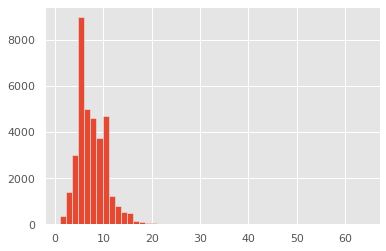

time: 356 ms (started: 2021-09-05 20:05:59 +00:00)


In [15]:
plt.style.use("ggplot")
plt.hist([len(s) for s in set(data["Word"].values)], bins=50)
plt.show()

In [16]:
data.loc[data['Tag'] == 'B-org', 'Word'].head()

97             Labor
154    International
215             IAEA
234         European
248             U.N.
Name: Word, dtype: object

time: 75.4 ms (started: 2021-09-05 20:05:59 +00:00)


In [17]:
data.loc[data['Tag'] == 'B-per', 'Word'].head()

42          Bush
270    President
331       Thomas
443    President
965      Prophet
Name: Word, dtype: object

time: 73.3 ms (started: 2021-09-05 20:05:59 +00:00)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


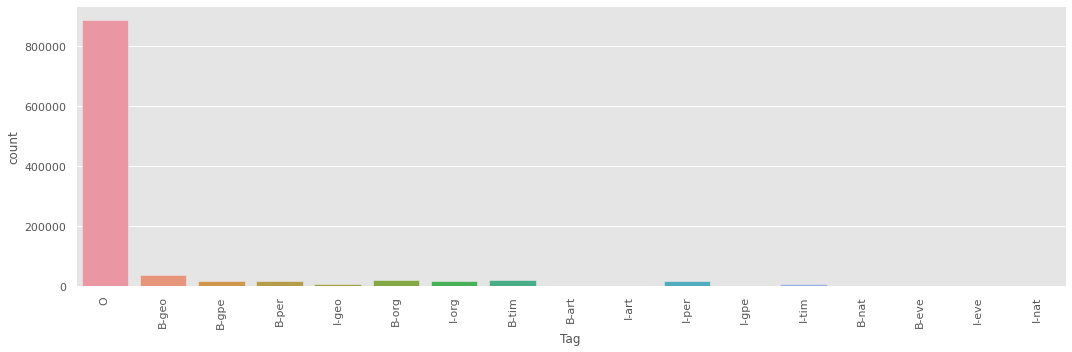

time: 850 ms (started: 2021-09-05 20:05:59 +00:00)


In [18]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('Tag', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

These words can be considered as fillers and their presence might impact the classifier performance as well.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


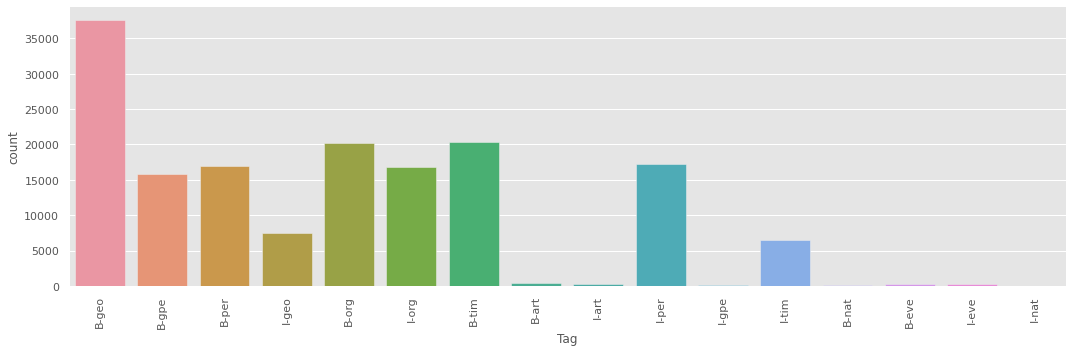

time: 583 ms (started: 2021-09-05 20:06:00 +00:00)


In [19]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('Tag', data=data.loc[data['Tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

So our dataset mostly contains words related to geographical locations, geopolitical entities and person names.



In [20]:
data["Sentence #"] = LabelEncoder().fit_transform(data["Sentence #"] )


time: 226 ms (started: 2021-09-05 20:06:01 +00:00)


Fit label encoder and return encoded labels.



In [21]:
data.rename(columns={"Sentence #":"sentence_id","Word":"words","Tag":"labels"}, inplace =True)


time: 1.74 ms (started: 2021-09-05 20:06:01 +00:00)


In [22]:
data["labels"] = data["labels"].str.upper()

time: 321 ms (started: 2021-09-05 20:06:01 +00:00)


In [23]:
X= data[["sentence_id","words"]]
Y =data["labels"]

time: 14.1 ms (started: 2021-09-05 20:06:01 +00:00)


In [24]:
print(X)

         sentence_id          words
0                  0      Thousands
1                  0             of
2                  0  demonstrators
3                  0           have
4                  0        marched
...              ...            ...
1048570        42177           they
1048571        42177      responded
1048572        42177             to
1048573        42177            the
1048574        42177         attack

[1048575 rows x 2 columns]
time: 9.2 ms (started: 2021-09-05 20:06:01 +00:00)


In [25]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size =0.2)


time: 288 ms (started: 2021-09-05 20:06:01 +00:00)


In [26]:
train_data = pd.DataFrame({"sentence_id":x_train["sentence_id"],"words":x_train["words"],"labels":y_train})
test_data = pd.DataFrame({"sentence_id":x_test["sentence_id"],"words":x_test["words"],"labels":y_test})

time: 55.1 ms (started: 2021-09-05 20:06:02 +00:00)


In [27]:
train_data


,sentence_id,words,labels
1288,42960,to,O
695162,24196,stole,O
181268,46070,France,B-GEO
823946,30733,has,O
786422,28836,White,B-ORG
...,...,...,...
841737,31636,spies,O
869252,33018,an,O
420416,10219,eastern,O
315929,4960,the,O


time: 13.4 ms (started: 2021-09-05 20:06:02 +00:00)


In [28]:
label = data["labels"].unique().tolist()

time: 59.7 ms (started: 2021-09-05 20:06:02 +00:00)


In [29]:
label

['O',
 'B-GEO',
 'B-GPE',
 'B-PER',
 'I-GEO',
 'B-ORG',
 'I-ORG',
 'B-TIM',
 'B-ART',
 'I-ART',
 'I-PER',
 'I-GPE',
 'I-TIM',
 'B-NAT',
 'B-EVE',
 'I-EVE',
 'I-NAT']

time: 2.58 ms (started: 2021-09-05 20:06:02 +00:00)


In [30]:
args = NERArgs()
args.num_train_epochs = 1
args.learning_rate = 5e-5
args.overwrite_output_dir =True

args.train_batch_size = 64
args.eval_batch_size = 64
args.max_seq_length = 128

time: 1.13 ms (started: 2021-09-05 20:06:02 +00:00)


Default Parameters:
"fp16": True,
"fp16_opt_level": "O1",
"max_seq_length": 128,
"train_batch_size": 8,
"gradient_accumulation_steps": 1,
"eval_batch_size": 8,
"num_train_epochs": 1,
"weight_decay": 0,
"learning_rate": 4e-5,
"adam_epsilon": 1e-8,
"warmup_ratio": 0.06,
"warmup_steps": 0,
"max_grad_norm": 1.0,
"logging_steps": 50,
"save_steps": 2000


In [31]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

time: 150 ms (started: 2021-09-05 20:06:02 +00:00)


Cleanin the cache.

In [32]:
model = NERModel('bert', 'bert-base-cased',labels=label,args =args)


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

time: 27.8 s (started: 2021-09-05 20:06:02 +00:00)


bert-base-cased: 12-layer, 768-hidden, 12-heads, 109M parameters.
Trained on cased English text.

In [33]:
model.train_model(train_data,eval_data = test_data,acc=accuracy_score)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/750 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/ner/ner_model.py:775: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(750, 0.23118143781026204)

time: 6min 52s (started: 2021-09-05 20:06:30 +00:00)


In [34]:
result, model_outputs, preds_list = model.eval_model(test_data)


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/729 [00:00<?, ?it/s]

time: 3min 12s (started: 2021-09-05 20:13:22 +00:00)


In [35]:
result

{'eval_loss': 0.1751648922219607,
 'precision': 0.8257657220160255,
 'recall': 0.7593620414673046,
 'f1_score': 0.7911730005483639}

time: 2.58 ms (started: 2021-09-05 20:16:34 +00:00)


In [36]:
df = pd.read_csv("AWD_data.csv")

time: 30.3 ms (started: 2021-09-05 20:16:34 +00:00)


In [37]:
text = df["Text"]

time: 924 µs (started: 2021-09-05 20:16:35 +00:00)


In [38]:
words = list(text)
n_words = len(words)
print("Number of days in the dataset: ", n_words)


Number of days in the dataset:  2024
time: 2.4 ms (started: 2021-09-05 20:16:35 +00:00)


In [39]:
text.head(5)

0    Went to Halston's birthday dinner for Victor a...
1    I had to meet Miguel Bose (cab $6). He came to...
2    Henry Geldzahler came by to talk about me doin...
3    I was reading the Margaret Trudeau book. She w...
4    We photographed the street people in front of ...
Name: Text, dtype: object

time: 3.77 ms (started: 2021-09-05 20:16:35 +00:00)


In [40]:
count = 0
for totalwords in text:
    count += len(totalwords)

print('Total Words : ', count)

Total Words :  2246989
time: 2.42 ms (started: 2021-09-05 20:16:35 +00:00)


In [41]:
day1 = text[0]
day1

'Went to Halston\'s birthday dinner for Victor at Pearl\'s he did not want to do a big thing at the house. Joe Eula was there. And Aly Kaiser. She has two bodyguards now because of her Greek husband that she is divorcing-she has one bodyguard driving her and one at home. She had as a present for Victor a bag of Hawaiian marijuana that a couple of fag friends who have a ranch there mailed to her in a box of perfumed shirts so you would not smell the marijuana. She said she gave some to one of her bodyguards and he was passed out at home. She says she will let me take pictures of her as soon as she gets her divorce. Before it was "as soon as I get the plastic in my face from Dr. Orentreich." I talked to Dr. Giller he seems so sensible. He said that only fish and chicken and fresh vegetables were good for you even though he himself liked Chinese food. He told Mrs. Kaiser where she could get fresh chickens kosher on the Lower East Side and she said she would send one of her bodyguards down

time: 2.17 ms (started: 2021-09-05 20:16:35 +00:00)


In [42]:
abbreviations = {'Dr.': 'doctor', 'Mr.': 'mister', 'bro.': 'brother', 'bro': 'brother', 'Mrs.': 'mistress', 'Ms.': 'miss', 'jr.': 'junior', 'sr.': 'senior', 'i.e.': 'for example', 'e.g.': 'for example', 'vs.': 'versus'}
terminators = ['.', '!', '?']
wrappers = ['"', "'", ')', ']', '}']


def find_sentences(paragraph):
   end = True
   sentences = []
   while end > -1:
       end = find_sentence_end(paragraph)
       if end > -1:
           sentences.append(paragraph[end:].strip())
           paragraph = paragraph[:end]
   sentences.append(paragraph)
   sentences.reverse()
   return sentences

def find_sentence_end(paragraph):
    [possible_endings, contraction_locations] = [[], []]
    contractions = abbreviations.keys()
    sentence_terminators = terminators + [terminator + wrapper for wrapper in wrappers for terminator in terminators]
    for sentence_terminator in sentence_terminators:
        t_indices = list(find_all(paragraph, sentence_terminator))
        possible_endings.extend(([] if not len(t_indices) else [[i, len(sentence_terminator)] for i in t_indices]))
    for contraction in contractions:
        c_indices = list(find_all(paragraph, contraction))
        contraction_locations.extend(([] if not len(c_indices) else [i + len(contraction) for i in c_indices]))
    possible_endings = [pe for pe in possible_endings if pe[0] + pe[1] not in contraction_locations]
    if len(paragraph) in [pe[0] + pe[1] for pe in possible_endings]:
        max_end_start = max([pe[0] for pe in possible_endings])
        possible_endings = [pe for pe in possible_endings if pe[0] != max_end_start]
    possible_endings = [pe[0] + pe[1] for pe in possible_endings if sum(pe) > len(paragraph) or (sum(pe) < len(paragraph) and paragraph[sum(pe)] == ' ')]
    end = (-1 if not len(possible_endings) else max(possible_endings))
    return end


def find_all(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1:
            return
        yield start
        start += len(sub)

time: 4.32 ms (started: 2021-09-05 20:16:35 +00:00)


In [43]:
day1pred = find_sentences(day1)

time: 1.85 ms (started: 2021-09-05 20:16:35 +00:00)


In [44]:
day1pred

["Went to Halston's birthday dinner for Victor at Pearl's he did not want to do a big thing at the house.",
 'Joe Eula was there.',
 'And Aly Kaiser.',
 'She has two bodyguards now because of her Greek husband that she is divorcing-she has one bodyguard driving her and one at home.',
 'She had as a present for Victor a bag of Hawaiian marijuana that a couple of fag friends who have a ranch there mailed to her in a box of perfumed shirts so you would not smell the marijuana.',
 'She said she gave some to one of her bodyguards and he was passed out at home.',
 'She says she will let me take pictures of her as soon as she gets her divorce.',
 'Before it was "as soon as I get the plastic in my face from Dr. Orentreich."',
 'I talked to Dr. Giller he seems so sensible.',
 'He said that only fish and chicken and fresh vegetables were good for you even though he himself liked Chinese food.',
 'He told Mrs. Kaiser where she could get fresh chickens kosher on the Lower East Side and she said sh

time: 2.49 ms (started: 2021-09-05 20:16:35 +00:00)


In [45]:
all = []
for day in text:
  sentences = find_sentences(day)
  for sentence in sentences:
    all.append(sentence)

time: 1.67 s (started: 2021-09-05 20:16:35 +00:00)


In [46]:
predictiontest, model_output3 = model.predict(all)

  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/437 [00:00<?, ?it/s]

time: 1min 56s (started: 2021-09-05 20:16:36 +00:00)


In [47]:
predictiontest[0]

[{'Went': 'O'},
 {'to': 'O'},
 {"Halston's": 'I-PER'},
 {'birthday': 'O'},
 {'dinner': 'O'},
 {'for': 'O'},
 {'Victor': 'B-PER'},
 {'at': 'O'},
 {"Pearl's": 'B-PER'},
 {'he': 'O'},
 {'did': 'O'},
 {'not': 'O'},
 {'want': 'O'},
 {'to': 'O'},
 {'do': 'O'},
 {'a': 'O'},
 {'big': 'O'},
 {'thing': 'O'},
 {'at': 'O'},
 {'the': 'O'},
 {'house.': 'O'}]

time: 5.7 ms (started: 2021-09-05 20:18:33 +00:00)


In [48]:
peoplelistnotpair=[]
for elem in predictiontest:
  for elem2 in elem:
    for word, value in elem2.items():
      if value == 'B-PER' or value == 'I-PER' :
        peoplelistnotpair.append(word)


time: 168 ms (started: 2021-09-05 20:18:33 +00:00)


In [49]:
peoplelistnotpair[:5]

["Halston's", 'Victor', "Pearl's", 'Joe', 'Eula']

time: 3.18 ms (started: 2021-09-05 20:18:33 +00:00)


In [50]:
len(peoplelistnotpair)

31388

time: 2.74 ms (started: 2021-09-05 20:18:33 +00:00)


In [51]:
Counter(peoplelistnotpair).most_common(10)

[('Bob', 564),
 ('Fred', 562),
 ('John', 378),
 ('Halston', 320),
 ('Jean', 319),
 ('Bianca', 311),
 ('Michel', 283),
 ('Victor', 264),
 ('Jon', 256),
 ('Chris', 256)]

time: 14.7 ms (started: 2021-09-05 20:18:33 +00:00)


In [52]:
prevalue="" 
preword=""
peoplepair=[]
for elem in predictiontest:
  for elem2 in elem:

    for word, value in elem2.items():

      newstring=""
      if value == 'B-PER' or value == 'I-PER' :
        if value == 'I-PER' and prevalue == 'B-PER':
          newstring = str(preword) + " " + str(word)
          del peoplepair[-1]
        else:
          newstring=word
        peoplepair.append(newstring)
        prevalue=value
        preword=word

time: 186 ms (started: 2021-09-05 20:18:33 +00:00)


In [53]:
peoplepair[:50]

["Halston's",
 'Victor',
 "Pearl's",
 'Joe Eula',
 'Aly',
 'Victor',
 'Dr. Orentreich."',
 'Dr. Giller',
 'Mrs. Kaiser',
 'Miguel Bose',
 'Joe MacDonald',
 'Joe',
 'Veronica',
 'Muhammad Ali',
 'Ronnie Levin',
 'Muhammad',
 'Henry Geldzahler',
 'Fred',
 'Henry',
 'Henry',
 'Ellsworth',
 'Kelly',
 'Ellsworth',
 'Kelly',
 'Mayor Koch',
 'Rupert',
 'Ron Feldman',
 'Santa Claus.',
 'Harcourt',
 'Jackie',
 'Curtis',
 'Jovanovich Brace',
 'Margaret Trudeau',
 'Mork',
 'Robin Williams.',
 "Jed's",
 "Susan Mork's",
 'Sherry',
 'Lucie Arnaz',
 'Mork',
 'Jon Woods',
 'Richard Weisman',
 'Howard Cosell',
 "Reggie Jackson's",
 "Averil Meyer's",
 'Mrs. Payson',
 'Averil',
 'Yogi Berra',
 'Mickey Mantle',
 'Howard Cosell']

time: 3.5 ms (started: 2021-09-05 20:18:34 +00:00)


In [54]:
len(peoplepair)

22210

time: 2.69 ms (started: 2021-09-05 20:18:34 +00:00)


In [55]:
Counter(peoplepair).most_common(10)

[('Fred', 489),
 ('Bob', 378),
 ('Jean Michel', 270),
 ('Bianca', 259),
 ('Basquiat', 233),
 ('Paige', 209),
 ('Brigid', 199),
 ('Victor', 198),
 ('Jon', 193),
 ('Halston', 189)]

time: 13.2 ms (started: 2021-09-05 20:18:34 +00:00)


In [56]:
from statistics import mean
  
def Average(lst):
    return mean(lst)

time: 5.97 ms (started: 2021-09-05 20:18:34 +00:00)


In [57]:
def list_duplicates_of(seq,item):
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs


time: 1.2 ms (started: 2021-09-05 20:18:34 +00:00)


In [58]:
fredfrequence = list_duplicates_of(peoplelistnotpair, 'Fred')
print(list_duplicates_of(peoplelistnotpair, 'Fred'))
print(len(fredfrequence))
print("Position of Fred =", round(Average(fredfrequence), 2))


[26, 80, 87, 89, 148, 300, 302, 304, 493, 515, 552, 553, 647, 721, 751, 803, 870, 1005, 1168, 1171, 1236, 1306, 1308, 1356, 1493, 1523, 1577, 1591, 1685, 1708, 1783, 1936, 2126, 2129, 2164, 2273, 2276, 2293, 2318, 2335, 2346, 2351, 2352, 2409, 2424, 2448, 2510, 2511, 2522, 2538, 2648, 2684, 2685, 2692, 2693, 2694, 2735, 2738, 2772, 2814, 3038, 3105, 3106, 3308, 3346, 3349, 3350, 3355, 3356, 3405, 3440, 3491, 3493, 3496, 3510, 3598, 3603, 3610, 3790, 3804, 3846, 3849, 3851, 4092, 4150, 4157, 4346, 4478, 4768, 4816, 4819, 4822, 4881, 4887, 4891, 4936, 4937, 4949, 4950, 4952, 4993, 5011, 5055, 5290, 5332, 5387, 5392, 5473, 5476, 5530, 5593, 5709, 5853, 5905, 5933, 6080, 6098, 6108, 6109, 6195, 6212, 6302, 6399, 6402, 6404, 6490, 6558, 6573, 6604, 6613, 6696, 6742, 6868, 6886, 6887, 6888, 6907, 6910, 6947, 6948, 6981, 7075, 7553, 7582, 7583, 7724, 7740, 7742, 7861, 7870, 7872, 7932, 8163, 8182, 8540, 8556, 8563, 8640, 8669, 8791, 8823, 8828, 8836, 9119, 9121, 9122, 9434, 9645, 9665, 9687, 

In [59]:
Jonfrequence = list_duplicates_of(peoplelistnotpair, 'Jon')
print(list_duplicates_of(peoplelistnotpair, 'Jon'))
print(len(Jonfrequence))
print("Position of Jon =", round(Average(Jonfrequence), 2))

[57, 343, 354, 423, 583, 779, 884, 890, 897, 899, 1145, 1146, 1152, 1176, 1264, 1353, 1768, 1771, 1888, 1891, 1970, 1980, 2302, 2485, 2676, 2733, 3011, 3123, 3314, 3316, 3317, 3330, 3881, 4109, 4431, 4553, 4833, 4934, 4935, 5338, 5581, 5794, 5930, 6162, 6307, 6367, 6381, 6472, 6473, 6958, 7296, 7301, 7328, 7533, 7534, 7623, 7629, 7637, 7640, 7645, 8636, 8767, 8769, 8995, 9294, 9387, 9388, 9389, 9390, 9394, 9668, 9733, 9779, 9780, 9976, 9982, 9987, 10110, 10113, 10114, 10119, 10256, 10261, 10317, 10320, 10933, 11109, 11132, 11134, 11268, 11278, 11290, 11756, 11770, 11772, 11775, 11777, 11792, 12010, 12072, 12247, 12324, 12328, 12362, 12363, 12382, 12444, 12453, 12459, 12468, 12535, 12692, 12707, 12855, 12898, 13167, 13168, 13378, 13686, 13790, 13872, 13929, 13958, 14007, 14094, 14100, 14116, 14209, 14393, 14395, 14396, 14398, 14399, 14400, 14569, 14632, 14635, 14695, 14707, 14711, 14820, 14948, 15432, 15433, 15513, 15640, 15674, 15808, 15818, 15820, 15825, 15827, 15839, 15946, 15956, 15

In [60]:
xfrequence = list_duplicates_of(peoplelistnotpair, 'Brigid')
print(list_duplicates_of(peoplelistnotpair, 'Brigid'))
print(len(xfrequence))
print("Position of x =", round(Average(xfrequence), 2))

[159, 167, 404, 501, 682, 822, 863, 985, 1007, 1010, 1237, 1780, 1912, 1928, 2091, 2229, 2843, 3477, 3564, 3805, 3808, 3844, 4127, 4165, 4256, 4471, 4496, 4647, 4835, 4927, 4933, 4954, 4974, 5103, 5120, 5121, 5122, 5129, 5131, 5132, 5344, 5906, 6344, 6350, 6509, 6685, 6775, 6796, 7361, 7606, 7707, 7712, 7960, 8752, 9053, 9054, 9055, 9658, 9671, 9847, 10108, 11191, 11350, 12350, 13070, 13277, 13376, 13785, 14284, 14286, 15016, 15118, 15363, 15641, 15712, 15747, 15748, 15750, 15901, 15929, 16269, 16289, 16324, 16327, 16499, 16662, 16665, 17010, 17030, 17036, 17039, 17372, 17449, 17528, 17946, 18580, 18932, 18940, 18945, 19043, 19356, 19357, 19361, 19362, 19364, 19373, 19378, 19379, 19384, 19385, 19390, 19391, 19394, 19398, 19401, 19460, 19537, 19572, 19573, 20033, 20034, 20352, 20439, 20457, 21012, 21242, 21248, 21454, 21488, 21492, 21637, 21766, 22056, 22075, 22227, 22327, 22467, 22483, 22963, 23028, 23077, 23081, 23471, 23525, 23592, 23610, 23611, 23612, 23705, 24121, 24776, 24779, 248

In [61]:
dayslist=[]
predictlist=[]
for days in text[:10]:
  predictionpeople, model_output3 = model.predict([days])
  predictlist.append(predictionpeople)
  prevalue="" 
  preword=""
  peoplelist=[]
  for elem in predictionpeople:
    for elem2 in elem:

      for word, value in elem2.items():

        newstring=""
        if value == 'B-PER' or value == 'I-PER' :
          if value == 'I-PER' and prevalue == 'B-PER':
            newstring = str(preword) + " " + str(word)

            del peoplelist[-1]
          else:
            newstring=word
          peoplelist.append(newstring)
          prevalue=value
          preword=word
  dayslist.append(peoplelist)

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

time: 4.61 s (started: 2021-09-05 20:18:34 +00:00)


In [103]:
dayslist

[["Halston's", 'Victor', "Pearl's", 'Joe Eula', 'Aly Kaiser.', 'Victor'],
 ['Miguel Bose',
  'Joe MacDonald',
  'Joe',
  'Veronica',
  'Muhammad Ali',
  'Ronnie Levin'],
 ['Henry Geldzahler',
  'Fred',
  'Henry',
  'Henry Ellsworth',
  'Kelly',
  'Ellsworth',
  'Kelly',
  'Mayor Koch'],
 ['Margaret Trudeau',
  'Mork',
  'Robin Williams.',
  "Jed's",
  "Susan Mork's",
  'Sherry',
  'Lucie Arnaz',
  'Mork'],
 ['Jon Woods'],
 ['Richard Weisman',
  'Howard Cosell',
  "Reggie Jackson's",
  'Averil',
  "Meyer's",
  'Mrs. Payson',
  'Averil',
  'Yogi Berra'],
 ['Coffman',
  'Pork',
  'Tony Coffman?',
  'Diana Vreeland',
  'Bob',
  'Michael',
  'Pat York.',
  'Carole Rogers',
  'Sally'],
 [],
 ['Moynihan', 'Maura', 'Dominique', 'Sanda Moynihan', 'Chris Makos'],
 ['Dr. Reese', "Bernsohn's-he", 'Reese', 'Reese', 'Reese']]

time: 3.55 ms (started: 2021-09-05 20:54:15 +00:00)


In [105]:
dayslist[0]

["Halston's", 'Victor', "Pearl's", 'Joe Eula', 'Aly Kaiser.', 'Victor']

time: 4.22 ms (started: 2021-09-05 20:57:17 +00:00)


In [62]:
geonotpair=[]
for elem in predictiontest:
  for elem2 in elem:
    for word, value in elem2.items():
      if value == 'B-GEO' or value == 'I-GEO' :
        geonotpair.append(word)

time: 179 ms (started: 2021-09-05 20:18:38 +00:00)


In [63]:
geonotpair[:5]

['Lower', 'East', 'Side', 'Spain', 'Beverly']

time: 2.54 ms (started: 2021-09-05 20:18:38 +00:00)


In [64]:
len(geonotpair)

4685

time: 1.95 ms (started: 2021-09-05 20:18:38 +00:00)


In [65]:
Counter(geonotpair).most_common(10)

[('New', 302),
 ('York', 252),
 ('Street', 143),
 ('Avenue', 105),
 ('Park', 91),
 ('West', 83),
 ('L.A.', 82),
 ('East', 78),
 ('Madison', 68),
 ('California', 62)]

time: 5.45 ms (started: 2021-09-05 20:18:38 +00:00)


In [66]:
prevalue="" 
preword=""
geopair=[]
for elem in predictiontest:
  for elem2 in elem:

    for word, value in elem2.items():

      newstring=""
      if value == 'B-GEO' or value == 'I-GEO' :
        if value == 'I-GEO' and prevalue == 'B-GEO':
          newstring = str(preword) + " " + str(word)

          del geopair[-1]
        else:
          newstring=word
        geopair.append(newstring)
        prevalue=value
        preword=word

time: 172 ms (started: 2021-09-05 20:18:38 +00:00)


In [67]:
geopair[:5]

['Lower East', 'Side', 'Spain', 'Beverly Hills', 'New York']

time: 2.47 ms (started: 2021-09-05 20:18:39 +00:00)


In [68]:
len(geopair)

3559

time: 3.5 ms (started: 2021-09-05 20:18:39 +00:00)


In [69]:
Counter(geopair).most_common(10)

[('New York', 174),
 ('L.A.', 69),
 ('California', 57),
 ('New York.', 48),
 ('St.', 45),
 ('Madison', 43),
 ('West', 41),
 ('Paris', 38),
 ('York', 37),
 ('Hollywood', 32)]

time: 18 ms (started: 2021-09-05 20:18:39 +00:00)


In [70]:
gpenotpair=[]
for elem in predictiontest:
  for elem2 in elem:
    for word, value in elem2.items():
      if value == 'B-GPE' or value == 'I-GPE' :
        gpenotpair.append(word)

time: 167 ms (started: 2021-09-05 20:18:39 +00:00)


In [71]:
Counter(gpenotpair).most_common(10)

[('American', 56),
 ('Italian', 42),
 ('French', 40),
 ('Chinese', 36),
 ('English', 31),
 ('Japanese', 31),
 ('Indian', 22),
 ('Iranian', 20),
 ('German', 20),
 ('Greek', 19)]

time: 3.29 ms (started: 2021-09-05 20:18:39 +00:00)


In [72]:
natnotpair=[]
for elem in predictiontest:
  for elem2 in elem:
    for word, value in elem2.items():
      if value == 'B-ART' or value == 'I-ART' :
        natnotpair.append(word)

Counter(natnotpair).most_common(10)

[]

time: 160 ms (started: 2021-09-05 20:18:39 +00:00)


In [73]:
natnotpair=[]
for elem in predictiontest:
  for elem2 in elem:
    for word, value in elem2.items():
      if value == 'B-TIM' or value == 'I-TIM' :
        natnotpair.append(word)

Counter(natnotpair).most_common(10)

[('night', 192),
 ('later', 154),
 ('morning', 121),
 ('Christmas', 89),
 ('two', 80),
 ('sixties', 73),
 ('afternoon', 72),
 ('three', 56),
 ('few', 53),
 ('afternoon.', 51)]

time: 174 ms (started: 2021-09-05 20:18:39 +00:00)


In [74]:
from transformers import pipeline

time: 815 µs (started: 2021-09-05 20:18:39 +00:00)


In [75]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

time: 745 µs (started: 2021-09-05 20:18:39 +00:00)


In [76]:
newmodel = "distilbert-base-uncased-finetuned-sst-2-english"
modelforsent = AutoModelForSequenceClassification.from_pretrained(newmodel)
tokenizerforsent = AutoTokenizer.from_pretrained(newmodel)

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

time: 10.5 s (started: 2021-09-05 20:18:39 +00:00)


In [77]:
classifier = pipeline("sentiment-analysis", model=modelforsent, tokenizer=tokenizerforsent)

time: 47.7 ms (started: 2021-09-05 20:18:50 +00:00)


In [78]:
results = classifier(["We are very happy to show you the 🤗 Transformers library.",
           "We hope you don't hate it."])
for result in results:
    print(f"label: {result['label']}, with score: {round(result['score'], 2)}")

label: POSITIVE, with score: 1.0
label: NEGATIVE, with score: 0.53
time: 127 ms (started: 2021-09-05 20:18:50 +00:00)


In [79]:
classifier(day1)

[{'label': 'POSITIVE', 'score': 0.8292306661605835}]

time: 282 ms (started: 2021-09-05 20:18:50 +00:00)


In [80]:
classifier(text[27],truncation=True)

[{'label': 'NEGATIVE', 'score': 0.9982399940490723}]

time: 156 ms (started: 2021-09-05 20:18:50 +00:00)


In [81]:
day1sentiment = classifier(day1pred)

time: 495 ms (started: 2021-09-05 20:18:50 +00:00)


In [82]:
day1pred

["Went to Halston's birthday dinner for Victor at Pearl's he did not want to do a big thing at the house.",
 'Joe Eula was there.',
 'And Aly Kaiser.',
 'She has two bodyguards now because of her Greek husband that she is divorcing-she has one bodyguard driving her and one at home.',
 'She had as a present for Victor a bag of Hawaiian marijuana that a couple of fag friends who have a ranch there mailed to her in a box of perfumed shirts so you would not smell the marijuana.',
 'She said she gave some to one of her bodyguards and he was passed out at home.',
 'She says she will let me take pictures of her as soon as she gets her divorce.',
 'Before it was "as soon as I get the plastic in my face from Dr. Orentreich."',
 'I talked to Dr. Giller he seems so sensible.',
 'He said that only fish and chicken and fresh vegetables were good for you even though he himself liked Chinese food.',
 'He told Mrs. Kaiser where she could get fresh chickens kosher on the Lower East Side and she said sh

time: 3.46 ms (started: 2021-09-05 20:18:51 +00:00)


In [83]:
day1sentiment

[{'label': 'NEGATIVE', 'score': 0.9944120049476624},
 {'label': 'POSITIVE', 'score': 0.9985529780387878},
 {'label': 'POSITIVE', 'score': 0.9982966780662537},
 {'label': 'NEGATIVE', 'score': 0.9773986339569092},
 {'label': 'NEGATIVE', 'score': 0.9892184138298035},
 {'label': 'NEGATIVE', 'score': 0.9994540810585022},
 {'label': 'NEGATIVE', 'score': 0.9250573515892029},
 {'label': 'NEGATIVE', 'score': 0.998023509979248},
 {'label': 'POSITIVE', 'score': 0.9977026581764221},
 {'label': 'NEGATIVE', 'score': 0.9916772842407227},
 {'label': 'NEGATIVE', 'score': 0.9986087679862976},
 {'label': 'POSITIVE', 'score': 0.9962480664253235},
 {'label': 'POSITIVE', 'score': 0.9998703002929688},
 {'label': 'NEGATIVE', 'score': 0.9959911704063416}]

time: 4.44 ms (started: 2021-09-05 20:18:51 +00:00)


In [84]:
myvalues = [i['label'] for i in day1sentiment if 'label' in i]
myvalues

['NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE']

time: 2.82 ms (started: 2021-09-05 20:18:51 +00:00)


In [85]:
Counter(myvalues).most_common(2)

[('NEGATIVE', 9), ('POSITIVE', 5)]

time: 2.4 ms (started: 2021-09-05 20:18:51 +00:00)


In [86]:
x = len(list(filter(lambda item: item['label'] == 'POSITIVE', day1sentiment)))-len(list(filter(lambda item: item['label'] == 'NEGATIVE', day1sentiment)))

if x > 0:
   print("Day is POSITIVE")
else:
   print("Day is NEGATIVE")



Day is NEGATIVE
time: 1.68 ms (started: 2021-09-05 20:18:51 +00:00)


In [87]:
daysentiment = []

for i in range(len(text)):
    sentiment = classifier(text[i], truncation=True)
    daysentiment.append(sentiment)

time: 7min 6s (started: 2021-09-05 20:18:51 +00:00)


In [88]:
daysentiment[:10]

[[{'label': 'POSITIVE', 'score': 0.8292306661605835}],
 [{'label': 'NEGATIVE', 'score': 0.9951279163360596}],
 [{'label': 'NEGATIVE', 'score': 0.9992353916168213}],
 [{'label': 'POSITIVE', 'score': 0.9986928105354309}],
 [{'label': 'POSITIVE', 'score': 0.9863670468330383}],
 [{'label': 'NEGATIVE', 'score': 0.9987137317657471}],
 [{'label': 'NEGATIVE', 'score': 0.995424211025238}],
 [{'label': 'POSITIVE', 'score': 0.9998289346694946}],
 [{'label': 'NEGATIVE', 'score': 0.9992287158966064}],
 [{'label': 'POSITIVE', 'score': 0.5976727604866028}]]

time: 4.35 ms (started: 2021-09-05 20:25:58 +00:00)


In [89]:
daysentiment[150]

[{'label': 'NEGATIVE', 'score': 0.6932345032691956}]

time: 2.21 ms (started: 2021-09-05 20:25:58 +00:00)


In [90]:
daysentiment[2023]

[{'label': 'NEGATIVE', 'score': 0.994627058506012}]

time: 2.05 ms (started: 2021-09-05 20:25:58 +00:00)


In [91]:
len(daysentiment)

2024

time: 2.02 ms (started: 2021-09-05 20:25:58 +00:00)


In [95]:
totalsentiment=[]
for elem in daysentiment[:2023]:
 basic_sentiment = [i['label'] for i in elem if 'label' in i]
 totalsentiment.append(basic_sentiment)


print(totalsentiment[:10])


[['POSITIVE'], ['NEGATIVE'], ['NEGATIVE'], ['POSITIVE'], ['POSITIVE'], ['NEGATIVE'], ['NEGATIVE'], ['POSITIVE'], ['NEGATIVE'], ['POSITIVE']]
time: 2.65 ms (started: 2021-09-05 20:27:01 +00:00)


In [96]:
mergedtotalsentiment = list(itertools.chain(*totalsentiment))

time: 838 µs (started: 2021-09-05 20:27:05 +00:00)


In [97]:
mergedtotalsentiment[:10]

['POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE']

time: 3.11 ms (started: 2021-09-05 20:27:10 +00:00)


In [98]:
Counter(mergedtotalsentiment).most_common(2)

[('NEGATIVE', 1558), ('POSITIVE', 465)]

time: 2.65 ms (started: 2021-09-05 20:27:12 +00:00)
